In [1]:
import sys
print(sys.executable)

c:\Users\Sumfl\OneDrive\Documents\GitHub\ctc-esg\model-training\.venv\Scripts\python.exe


In [3]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from statsmodels.tsa.seasonal import seasonal_decompose #for dealing with seasonality in data
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA

In [5]:
#loading the time series data 
data = pd.read_csv(r'C:\Users\Sumfl\OneDrive\Documents\GitHub\ctc-esg\model-training\chillerdata1.csv')

In [6]:
data.head()

,Datetime,CHL_POW_1
0,1/1/2018 1:00,69.507398
1,1/1/2018 1:01,66.280762
2,1/1/2018 1:02,63.233582
3,1/1/2018 1:03,66.893384
4,1/1/2018 1:04,91.014646


In [8]:
# 1. Convert to datetime, explicitly telling Pandas the Day is first
data['Datetime'] = pd.to_datetime(data['Datetime'], dayfirst=True)

# 2. Set as index
data.set_index('Datetime', inplace=True)

# 3. Handle the 1-minute frequency
# Note: 'min' is the same as 'T' (minutes)
data = data.asfreq('min')

# 4. Check if we have missing values (gaps in the timeline)
print(data.isnull().sum())

CHL_POW_1    0
dtype: int64


In [9]:
data.head()

,CHL_POW_1
Datetime,
2018-01-01 01:00:00,69.507398
2018-01-01 01:01:00,66.280762
2018-01-01 01:02:00,63.233582
2018-01-01 01:03:00,66.893384
2018-01-01 01:04:00,91.014646


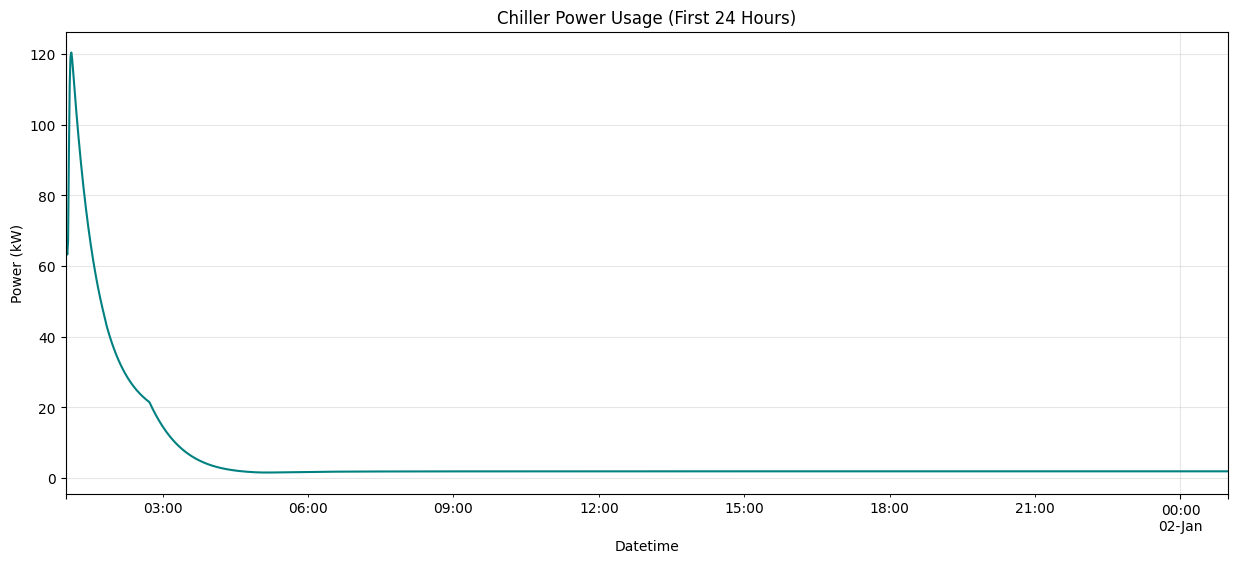

In [12]:
import matplotlib.pyplot as plt

# Plotting the first 24 hours to see the daily cycle clearly
# (Adjust '1440' if you want to see more or less; 1440 mins = 1 day)
data['CHL_POW_1'][:1440].plot(figsize=(15, 6), color='teal')
plt.title('Chiller Power Usage (First 24 Hours)')
plt.ylabel('Power (kW)')
plt.grid(True, alpha=0.3)
plt.show()

<Axes: xlabel='Datetime'>

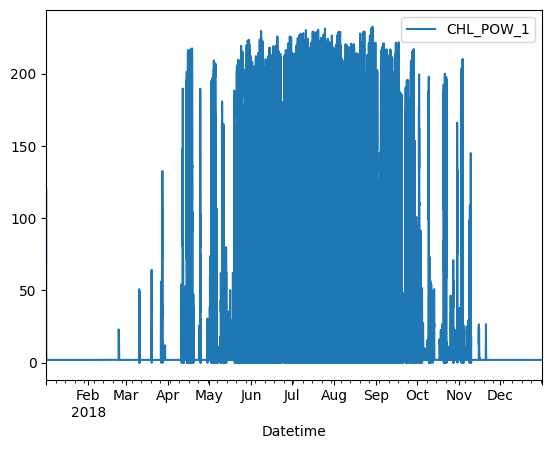

In [13]:
data.plot()

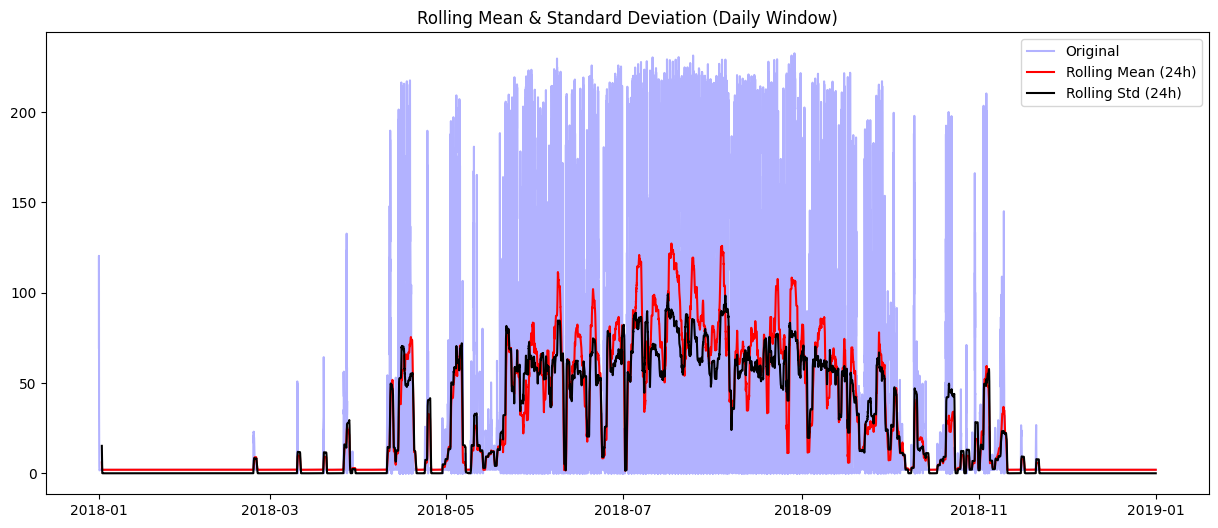

In [14]:
# 1. Calculating Rolling Statistics
# window=1440 because your data is in minutes (60min * 24hrs = 1 day)
rolling_mean = data['CHL_POW_1'].rolling(window=1440).mean()
rolling_std = data['CHL_POW_1'].rolling(window=1440).std()

# 2. Plotting
plt.figure(figsize=(15, 6))
plt.plot(data['CHL_POW_1'], color='blue', label='Original', alpha=0.3) # Added alpha to see the mean better
plt.plot(rolling_mean, color='red', label='Rolling Mean (24h)')
plt.plot(rolling_std, color='black', label='Rolling Std (24h)')

plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation (Daily Window)')
plt.show()

In [15]:
from statsmodels.tsa.stattools import adfuller

# Run the test
result = adfuller(data['CHL_POW_1'])

# Display the main numbers
print(f'Test Statistic: {result[0]}')
print(f'p-value: {result[1]}')

# Display the "Finish Line" markers (Critical Values)
for key, value in result[4].items():
    print(f'Critical Value ({key}): {value}')

Test Statistic: -21.51083897147775
p-value: 0.0
Critical Value (1%): -3.430362445534655
Critical Value (5%): -2.8615455007804154
Critical Value (10%): -2.5667729278643754


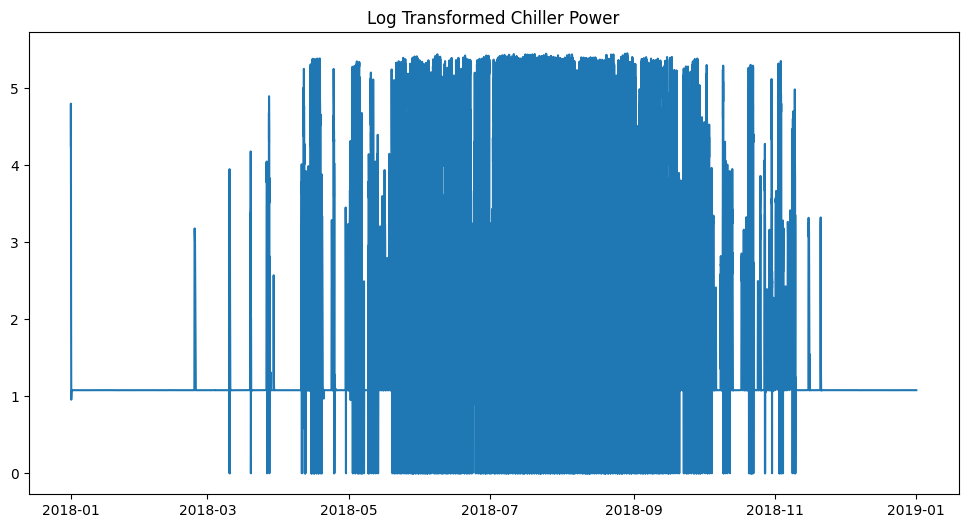

In [16]:
import numpy as np

# 1. Log transformation (adding 1 to handle 0-power moments)
first_log = np.log(data['CHL_POW_1'] + 1)

# 2. Visualize
plt.figure(figsize=(12,6))
plt.plot(first_log)
plt.title('Log Transformed Chiller Power')
plt.show()

Text(0.5, 1.0, 'Rolling Mean & Standard Deviation (Logarithmic Scale)')

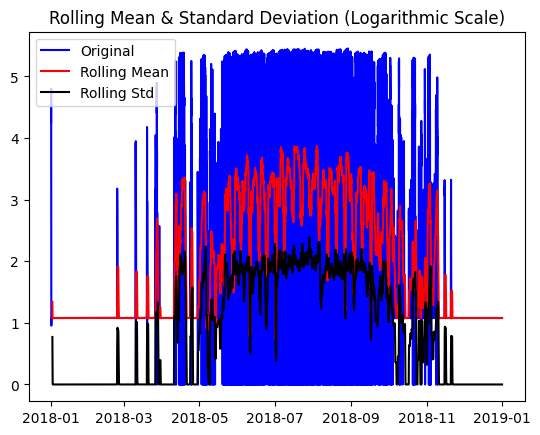

In [19]:
mean_log = first_log.rolling(window=1440).mean()
std_log = first_log.rolling(window=1440).std()

plt.plot(first_log, color='blue', label='Original')
plt.plot(mean_log, color='red', label='Rolling Mean')
plt.plot(std_log, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation (Logarithmic Scale)')

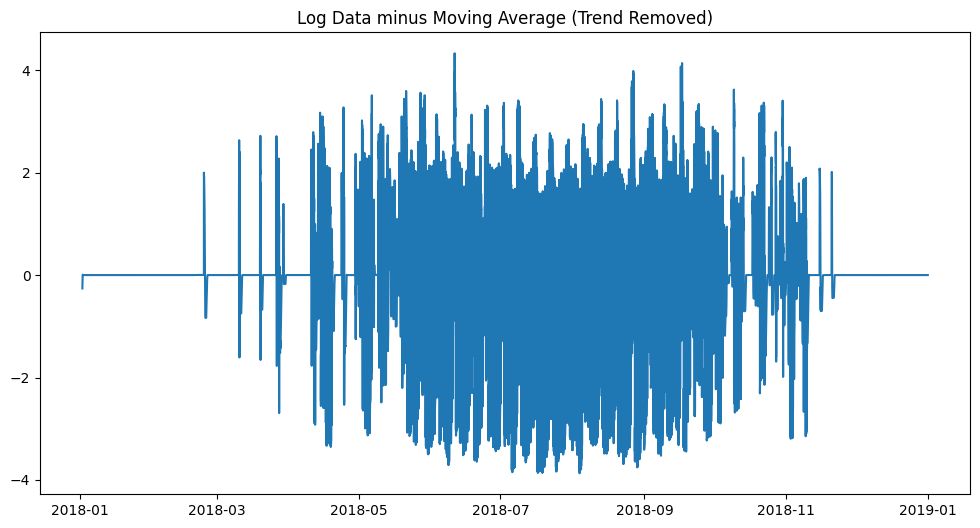

In [20]:
# Calculate the moving average of the log-transformed data
moving_avg = first_log.rolling(window=1440).mean()

# Subtract the moving average from the logged data
log_moving_avg_diff = first_log - moving_avg

# Since we used a window of 1440, the first 1439 rows will be NaN. We must drop them.
log_moving_avg_diff.dropna(inplace=True)

# Visualize the result
plt.figure(figsize=(12,6))
plt.plot(log_moving_avg_diff)
plt.title('Log Data minus Moving Average (Trend Removed)')
plt.show()

In [21]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# We use your variable name 'log_moving_avg_diff' here
result = adfuller(log_moving_avg_diff)

# This organizes the results exactly like the GitHub guide
result_data2 = pd.Series(result[0:3], index=['Test Statistic', 'p-value', 'Lags Used'])

print("--- ADF Test Results (After Detrending) ---")
print(result_data2)

# Quick logic check
if result[1] <= 0.05:
    print("\nInference: The data is now stationary. Ready for ARIMA!")
else:
    print("\nInference: Still not stationary. We might need more transformations.")

--- ADF Test Results (After Detrending) ---
Test Statistic   -27.935433
p-value            0.000000
Lags Used         93.000000
dtype: float64

Inference: The data is now stationary. Ready for ARIMA!


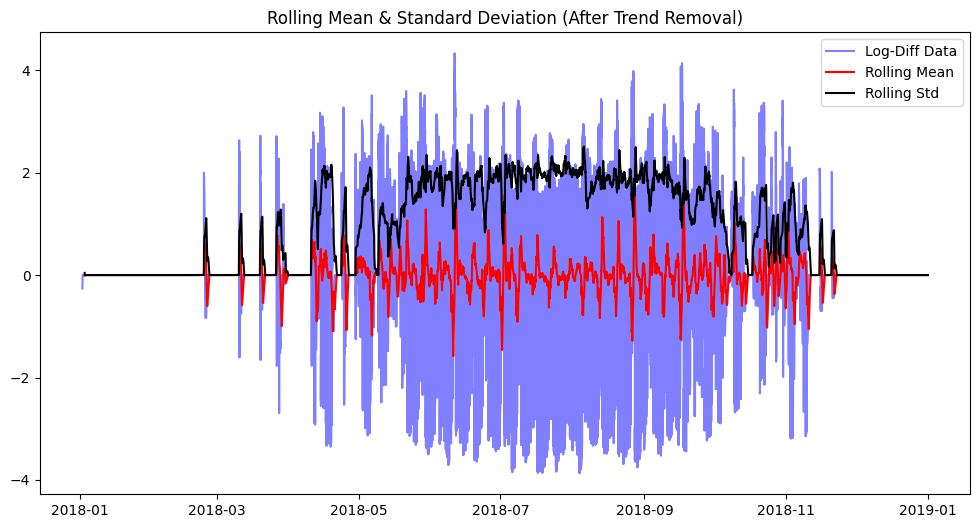

In [23]:
# 1. Use your specific variable and a 24-hour window
mean_log = log_moving_avg_diff.rolling(window=1440).mean()
std_log = log_moving_avg_diff.rolling(window=1440).std()

# 2. Plotting
plt.figure(figsize=(12,6))
plt.plot(log_moving_avg_diff, color='blue', label='Log-Diff Data', alpha=0.5) # alpha makes it easier to see lines on top
plt.plot(mean_log, color='red', label='Rolling Mean')
plt.plot(std_log, color='black', label='Rolling Std')

plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation (After Trend Removal)')
plt.show()

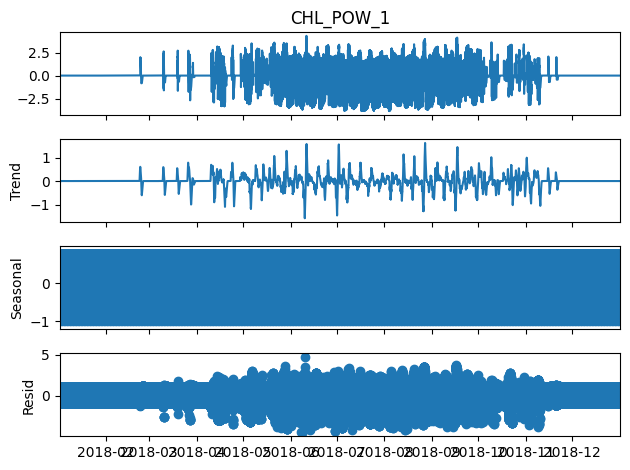

In [24]:
from statsmodels.tsa.seasonal import seasonal_decompose

# 1. We use your variable name
# 2. We set period=1440 to capture the DAILY cycle of the chiller
decompose_result = seasonal_decompose(log_moving_avg_diff, model='additive', period=1440)

# 3. This generates the 4-part plot (Observed, Trend, Seasonal, Resid)
decompose_result.plot()
plt.show()

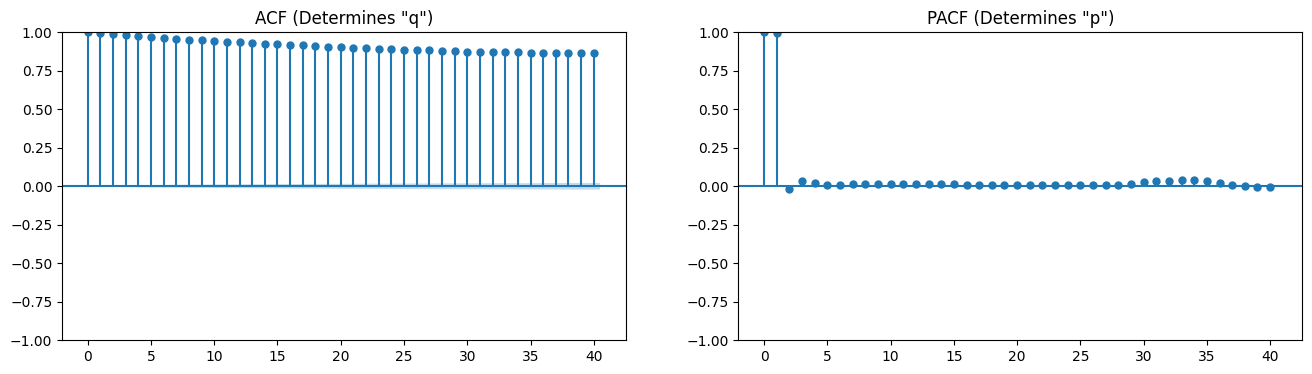

In [22]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# We use the log_moving_avg_diff data we just verified
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

# Plot ACF
plot_acf(log_moving_avg_diff, ax=axes[0], lags=40)
axes[0].set_title('ACF (Determines "q")')

# Plot PACF
plot_pacf(log_moving_avg_diff, ax=axes[1], lags=40)
axes[1].set_title('PACF (Determines "p")')

plt.show()